In [ ]:
from fastai.text.all import *

In [ ]:
lang = 'de'
backwards = False
bs=128
vocab_sz = 15000
num_workers=18
step = 'ft' # fine-tuning

In [ ]:
direction = 'fwd' if backwards == False else 'bwd'

In [ ]:
wiki = f'{lang}wiki'
base_path = Path('data')
path = base_path/wiki
model_base_path = path/'model'
model_path = model_base_path/step/direction
spm_path = model_base_path/step/'spm'
lm_fns = [(model_base_path/'lm'/direction/f'{lang}_wikitext_model').absolute(), 
          (model_base_path/'lm'/direction/f'{lang}_wikitext_vocab').absolute()]

In [ ]:
data_path = path/'germeval'

In [ ]:
lm_fns, spm_path, direction, backwards

([Path('/data/projects/git/fastai_ulmfit/data/dewiki/model/lm/bwd/de_wikitext_model'),
  Path('/data/projects/git/fastai_ulmfit/data/dewiki/model/lm/bwd/de_wikitext_vocab')],
 Path('data/dewiki/model/ft/spm'),
 'bwd',
 True)

## Prepare corpus for fine tuning

Prepare a .csv-file with a 'text' column to use this notebook for the language model fine-tuning. Otherwise you'll have to adjust the DataBlock / Dataloaders creation.

In [ ]:
df = pd.read_csv(data_path/'data_lm.csv')

In [ ]:
df

,text
0,"Meine Mutter hat mir erzählt, dass mein Vater einen Wahlkreiskandidaten nicht gewählt hat, weil der gegen die Homo-Ehe ist ☺"
1,"Meine Reaktion; Nicht jeder Moslem ist ein Terrorist. Aber jeder Moslem glaubt an Überlieferungen, die Gewalt und Terror begünstigen."
2,"#Merkel rollt dem Emir von #Katar, der islamistischen Terror unterstützt, den roten Teppich aus.Wir brauchen einen sofortigen #Waffenstopp!"
3,„Merle ist kein junges unschuldiges Mädchen“ Kch....... 😱 #tatort
4,Asylantenflut bringt eben nur negatives für Deutschland. Drum Asylanenstop und Rückführung der Mehrzahl.
...,...
512531,"🇪🇺 Keine Lust auf #Europa? Zurück zu nationalen Grenzen? Drei junge #Europäer wollten dabei nicht länger zusehen. Und gründeten #Volt. Eine Partei, die Europa einen soll. ⏩ #Europawahl2019"
512532,"Morgen um 11 Uhr geht die große Sprayer-Aktion an der Bahnunterführung in #Langen los. Wir sind total gespannt auf die Kunstwerke, die dort entstehen und verabschieden uns schon mal von den alten Schmierereien. Mehr Infos: #Graffiti #StreetArt"
512533,Neuigkeit: Gesundheitsgefahr: Krebshilfe fordert Werbeverbot für E-Zigaretten #news
512534,Hundeanhänger 925 Silber und recyceltes Holz sabina #Tchotchke #kreativerTchotchke #handgefertigt Cane ciondolo in argento 925 e sabina legno riciclato #gioielli #gioiellicreativi #fattoamano


## Fine tune model

We **don't reuse** the SentencePiece model trained on the Wikipedia corpus during fine-tuning. That might lead to slightly different tokenization, but fast.ai's language model learner takes care about adjusting the old / new vocabs. The language model fine-tuning will learn meaningful embeddings for the new tokens.

For the **forward / backard model** we'll use the same SentencePiece model.

In [ ]:
if spm_path.exists():
    tok = SentencePieceTokenizer(lang=lang, max_vocab_sz=vocab_sz, sp_model=spm_path/'spm.model')
    print(f'SentencePiece Model exists - using {spm_path}')
else:
    tok = SentencePieceTokenizer(lang=lang, max_vocab_sz=vocab_sz, cache_dir=spm_path)

SentencePiece Model exists - using data/dewiki/model/ft/spm


In [ ]:
dblocks = DataBlock(blocks=(TextBlock.from_df('text', tok=tok, is_lm=True, backwards=backwards)),
                    get_x=ColReader('text'), 
                    splitter=RandomSplitter(valid_pct=0.1, seed=42))
dls = dblocks.dataloaders(df, bs=bs, num_workers=num_workers)

/home/florian/miniconda3/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
dls.show_batch()

,text,text_
0,id str a ▁help ▁# mix my ▁match ▁# : ▁hier ▁dazu ▁infos ▁xxmaj ▁mehr ▁xxmaj ). ▁ländern ▁xxmaj ischen n afrika ▁west ▁anderen ▁aus ▁auch ▁aber ne ger ▁( nigeria ▁ ▁xxmaj ▁aus ▁einem ▁und ▁europa ▁xxmaj ▁aus teil ▁eltern ▁xxmaj ▁einem ▁je ▁mit erweise ▁ideal ▁xxmaj ! in * r spende n zelle stamm ▁ ▁xxmaj r * deutsche ro af ▁ e * ▁ein ▁wird ▁gesucht ▁xxmaj ️ !!,str a ▁help ▁# mix my ▁match ▁# : ▁hier ▁dazu ▁infos ▁xxmaj ▁mehr ▁xxmaj ). ▁ländern ▁xxmaj ischen n afrika ▁west ▁anderen ▁aus ▁auch ▁aber ne ger ▁( nigeria ▁ ▁xxmaj ▁aus ▁einem ▁und ▁europa ▁xxmaj ▁aus teil ▁eltern ▁xxmaj ▁einem ▁je ▁mit erweise ▁ideal ▁xxmaj ! in * r spende n zelle stamm ▁ ▁xxmaj r * deutsche ro af ▁ e * ▁ein ▁wird ▁gesucht ▁xxmaj ️ !! ▁
1,"▁xxmaj , kommen ▁an ▁xxmaj : ▁ich ▁finde ▁wichtig ▁xxmaj . ▁unnötig ▁für ▁ich ▁halte ziel ▁zeit ▁xxmaj ▁ein ▁durch ▁druck ▁xxmaj er ▁zusätzlich ▁xxmaj . ▁erfahrungen ▁xxmaj ▁und ▁eindrücke ▁xxmaj ▁neue ▁viele ▁so ▁es ▁gibt kampf ett ▁w ▁xxmaj ▁ersten ▁beim ▁gerade ▁xxmaj ▁xxbos ▁fort ▁griechenland ▁xxmaj ▁in a . ▁u ▁sich e ▁setzt ▁und ▁an ▁araber ▁xxmaj ▁die ▁durch ung ober er ▁ ▁xxmaj ▁der ▁nach tern p gy ä",", kommen ▁an ▁xxmaj : ▁ich ▁finde ▁wichtig ▁xxmaj . ▁unnötig ▁für ▁ich ▁halte ziel ▁zeit ▁xxmaj ▁ein ▁durch ▁druck ▁xxmaj er ▁zusätzlich ▁xxmaj . ▁erfahrungen ▁xxmaj ▁und ▁eindrücke ▁xxmaj ▁neue ▁viele ▁so ▁es ▁gibt kampf ett ▁w ▁xxmaj ▁ersten ▁beim ▁gerade ▁xxmaj ▁xxbos ▁fort ▁griechenland ▁xxmaj ▁in a . ▁u ▁sich e ▁setzt ▁und ▁an ▁araber ▁xxmaj ▁die ▁durch ung ober er ▁ ▁xxmaj ▁der ▁nach tern p gy ä ▁"
2,"▁schon ▁geht ▁xxmaj . gs son ▁lieblings ▁xxmaj ▁disney ▁xxmaj ▁meiner ▁einer ▁ist ▁world ▁new ▁whole ▁a ▁xxbos ▁stellen es ▁fall ▁xxmaj ▁des en ation lik p ▁im ▁xxmaj rechtlichen ▁menschen ▁den ▁aber ▁sich ▁muss r m eg ▁ ▁xxup ▁der ▁wurde en tritt s ▁be a vis ▁ ▁xxup humanitäre ▁ ▁für ständigkeit ▁zu ▁xxmaj ▁die erweise ios ▁kur ▁indem , gezogen ▁ affäre ▁ ▁xxmaj ▁der ▁aus ▁2017 ▁sich ▁hat","▁geht ▁xxmaj . gs son ▁lieblings ▁xxmaj ▁disney ▁xxmaj ▁meiner ▁einer ▁ist ▁world ▁new ▁whole ▁a ▁xxbos ▁stellen es ▁fall ▁xxmaj ▁des en ation lik p ▁im ▁xxmaj rechtlichen ▁menschen ▁den ▁aber ▁sich ▁muss r m eg ▁ ▁xxup ▁der ▁wurde en tritt s ▁be a vis ▁ ▁xxup humanitäre ▁ ▁für ständigkeit ▁zu ▁xxmaj ▁die erweise ios ▁kur ▁indem , gezogen ▁ affäre ▁ ▁xxmaj ▁der ▁aus ▁2017 ▁sich ▁hat ugh"
3,"▁anderer ▁mit ▁menschen ▁xxmaj ▁wenn ▁xxmaj . ▁klar ▁is , ▁ne ▁ja ▁xxmaj . ▁genauso ▁leuten ▁xxmaj ▁vielen ▁bei ▁ist ▁das ▁und ▁xxmaj . ▁so ▁ist ▁das ▁xxmaj . ▁schlecht ▁oder ▁gut ▁nicht ▁ist ▁das ▁xxmaj . ▁weiße ▁xxmaj ▁prozent ▁xxmaj ▁90 ▁über ▁zu ▁sitzen ▁bahn ▁xxmaj ▁meiner ▁in ▁xxmaj ▁xxbos rbl ▁hsv ▁xxup ▁# ▁dfbpokal ▁# ▁müssen ▁zu ▁machen ticket platz ▁steh ▁xxmaj ▁sein ▁um ▁sorgen ▁xxmaj ▁keine ▁sich ▁und ▁sein","▁mit ▁menschen ▁xxmaj ▁wenn ▁xxmaj . ▁klar ▁is , ▁ne ▁ja ▁xxmaj . ▁genauso ▁leuten ▁xxmaj ▁vielen ▁bei ▁ist ▁das ▁und ▁xxmaj . ▁so ▁ist ▁das ▁xxmaj . ▁schlecht ▁oder ▁gut ▁nicht ▁ist ▁das ▁xxmaj . ▁weiße ▁xxmaj ▁prozent ▁xxmaj ▁90 ▁über ▁zu ▁sitzen ▁bahn ▁xxmaj ▁meiner ▁in ▁xxmaj ▁xxbos rbl ▁hsv ▁xxup ▁# ▁dfbpokal ▁# ▁müssen ▁zu ▁machen ticket platz ▁steh ▁xxmaj ▁sein ▁um ▁sorgen ▁xxmaj ▁keine ▁sich ▁und ▁sein ▁zu"
4,▁xxup ▁wieso ▁xxup ▁xxbos ▁... ▁zeitung ▁xxmaj ▁keine ▁auch ▁vermutlich ▁lesen ▁die ▁aber ▁xxmaj . ▁nötig ▁bitter s tipp s ▁alltag ▁xxmaj ▁solche ▁hätten menschen ▁mit ▁xxmaj ▁viele ▁xxmaj : räumen ▁ein ▁man ▁muss ▁andererseits ▁xxmaj ▁xxbos monster zel t ▁kri ▁xxmaj ▁# . t leuchte ▁ ▁zunge ▁xxmaj ▁zu ▁schön ▁so ▁immer ▁danach ▁weil ▁xxmaj . cken mü os mo ▁leucht ▁xxmaj ▁liebsten ▁am st ▁is ▁und ge bir ▁ge ▁xxmaj,▁wieso ▁xxup ▁xxbos ▁... ▁zeitung ▁xxmaj ▁keine ▁auch ▁vermutlich ▁lesen ▁die ▁aber ▁xxmaj . ▁nötig ▁bitter s tipp s ▁alltag ▁xxmaj ▁solche ▁hätten menschen ▁mit ▁xxmaj ▁viele ▁xxmaj : räumen ▁ein ▁man ▁muss ▁andererseits ▁xxmaj ▁xxbos monster zel t ▁kri ▁xxmaj ▁# . t leuchte ▁ ▁zunge ▁xxmaj ▁zu ▁schön ▁so ▁immer ▁danach ▁weil ▁xxmaj . cken mü os mo ▁leucht ▁xxmaj ▁liebsten ▁am st ▁

In [ ]:
learn = language_model_learner(dls, AWD_LSTM, drop_mult=0.5, pretrained=True, pretrained_fnames=lm_fns, 
                               metrics=[accuracy, Perplexity()]).to_fp16()
learn.path = model_path

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.04786301031708717)

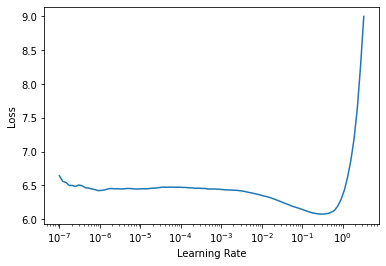

In [ ]:
learn.lr_find()

In [ ]:
lr = 3e-2

In [ ]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.274698,4.093458,0.340817,59.946812,02:15


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(lr/100,lr), moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.068278,3.932473,0.359489,51.033012,02:42
1,4.014465,3.883495,0.366970,48.593758,02:41
2,3.915109,3.793149,0.379014,44.395962,02:42
3,3.824833,3.725914,0.387506,41.509136,02:42
4,3.774954,3.664786,0.394962,39.047775,02:42
5,3.695723,3.600970,0.402666,36.633743,02:42
6,3.624130,3.542982,0.409899,34.569855,02:42
7,3.544222,3.495561,0.416163,32.968765,02:42
8,3.493506,3.467265,0.420178,32.048973,02:42
9,3.435243,3.462677,0.421081,31.902250,02:42


## Saving fine tuned model, encoder and vocab

In [ ]:
lm_ft_fns = [(model_path/f'{lang}_{step}_model').absolute(), 
             (model_path/f'{lang}_{step}_vocab.pkl').absolute()]

In [ ]:
learn.to_fp32()

In [ ]:
learn.save(lm_ft_fns[0], with_opt=False)

Path('/data/projects/git/fastai_ulmfit/data/dewiki/model/ft/bwd/de_ft_model.pth')

In [ ]:
learn.save_encoder((model_path/f'{lang}_{step}_encoder').absolute())

In [ ]:
with open(lm_ft_fns[1], 'wb') as f:
      pickle.dump(learn.dls.vocab, f)